In [11]:
import numpy
from matplotlib import colors
import matplotlib.pyplot as plt
from scipy import special
from scipy.optimize import minimize
import pandas as pd

In [3]:
# Register the color map to be used for plotting.
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)

In [12]:
pd.DataFrame(my_data)

,0,1,2
0,-0.954564,10.922566,0.0
1,9.273939,-5.891389,0.0
2,8.509064,-4.312051,0.0
3,7.409315,-3.759831,0.0
4,-1.448434,6.355646,0.0
...,...,...,...
1995,-2.384030,-2.089131,1.0
1996,-3.466043,-5.122045,1.0
1997,3.413610,-8.401729,1.0
1998,9.550863,-15.474605,1.0


In [4]:
# Read the data from the problem 3 file.
from numpy import genfromtxt
my_data = genfromtxt('logistic_regression.csv', delimiter=',', skip_header=1)
print(my_data.shape)
X = my_data[:, [0, 1]]
y = my_data[:, 2]

# Divide the data into two classes for plotting.
X0 = my_data[numpy.where(my_data[:, 2] == 0)]
X1 = my_data[numpy.where(my_data[:, 2] == 1)]

(2000, 3)


In [13]:
# Implements the natural log of the logistic function on $w^T x$.
def log_logistic_prob(iterate, x):
    t = numpy.dot(iterate[1:], x) + iterate[0]
    if t < -33:
        return t
    elif t < -18:
        return t - numpy.exp(t)
    elif t < 37:
        return -numpy.log1p(numpy.exp(- t ))
    else:
        return -numpy.exp(-t)

# Implements the logistic function on $w^T x$.
def logistic_prob(iterate, x):
    t = numpy.dot(iterate[1:], x) + iterate[0]
    if t < -33.3:
        return numpy.exp(t)
    elif t <= -18:
        return numpy.exp(t - numpy.exp(t))
    elif t <= 37:
        return numpy.exp(-numpy.log1p(numpy.exp(-t)))
    else:
        return numpy.exp(-numpy.exp(-t))

In [14]:
# Evaluates the logistic function on a set of grid points.
def logistic_prob_grid(iterate, grids):
    return numpy.array([logistic_prob(iterate, x) for x in grids ])

# Takes the logistic probability and thresholds to outputs a classification label.
def logistic_pred(iterate, x):
    return 1.0 if logistic_prob(iterate, x) > 0.5 else 0.0

In [15]:
# Implements the negative logistic regression objective. Modify me!
def negative_log_likelihood(iterate, X, y, regularization):
        
    # The accumulated objective value.
    obj_val = 0.0
        
    # Loop over each (x, y) pair.
    for i, (x_vec, y) in enumerate(zip(X, y)):
            
        # Dot product $w^T x$.            
        predict = iterate[0] + numpy.dot(iterate[1:], x_vec)
            
        # Accumulate the objective value contribution from this (x, y) pair.
        obj_val += (- (1 - y) * predict + log_logistic_prob(iterate, x_vec) )
    # Subtract the regularization parameter.
    return - obj_val + numpy.dot(regularization * iterate[1:], iterate[1:])

In [16]:
# Implements the logistic regression gradient. Modify me!
def gradient_negative_log_likelihood(iterate, X, y, regularization):
    gradient = numpy.zeros(3)
    
    # Loop over each (x, y) pair. 
    for i, (x_vec, y) in enumerate(zip(X, y)):
        
        # Dot product $w^T x$.            
        predict = iterate[0] + numpy.dot(iterate[1:], x_vec)
        
        if predict > 0.0:
            factor = ((y - 1) + y * numpy.exp(-predict)) / ( 1 + numpy.exp(-predict) )
        else:
            factor = ((y - 1) * numpy.exp(predict) + y ) / ( 1 + numpy.exp(predict) )
        gradient[0] -= factor
        gradient[1:] -= factor * x_vec
        
    # Regularize gradient.
    gradient[1:] += 2 * regularization * iterate[1:]
    
    return gradient

In [17]:
# Plots the data with the decision boundary.
def plot_data(X, y, iterate, regularization):
    y_pred = [logistic_pred(iterate, x) for x in X]
    tp = (y == y_pred)  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]
    
    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker='.', color='red')
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker='x',
                s=20, color='#990000')  # dark red

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker='.', color='blue')
    plt.scatter(X1_fp[:, 0], X1_fp[:, 1], marker='x',
                s=20, color='#000099')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 200
    x_min, x_max = (-10, 10)
    y_min, y_max = (-10, 10)
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    xx, yy = numpy.meshgrid(numpy.linspace(x_min, x_max, nx),
                         numpy.linspace(y_min, y_max, ny))
    
    # the classification line
    line = numpy.linspace(x_min, x_max, nx)
    plt.plot(line, -iterate[0]/iterate[2]-iterate[1]/iterate[2]*line, c = 'yellow')

    Z = logistic_prob_grid(iterate, numpy.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    neg_log_likelihood = negative_log_likelihood(iterate, X, y, regularization)
    plt.title(
        'Negative log likelihood: ' + str(neg_log_likelihood))
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
                   norm=colors.Normalize(0., 1.), zorder=0)
    
    # Plot my linear decision boundary here!
    
    plt.show()

In [18]:
# Plot for each different regularization value by calling your optimization routine for
# different values.

In [19]:
res = minimize(
    negative_log_likelihood, [-1,1,2], method = 'BFGS',
    jac = gradient_negative_log_likelihood, args=(X,y,numpy.array([0,0]),))

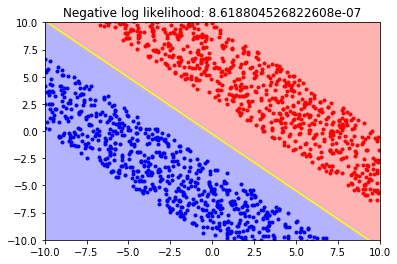

In [117]:
plot_data(X,y,res.x,0)

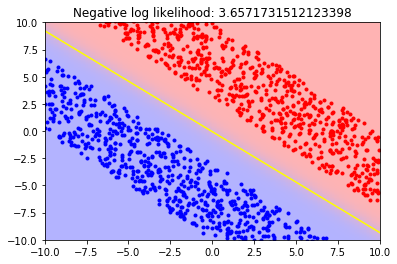

In [118]:
res_1_0 = minimize(
    negative_log_likelihood, [-1,1,2], method = 'BFGS',
    jac = gradient_negative_log_likelihood, args=(X,y,numpy.array([1,0]),))
plot_data(X,y,res_1_0.x,numpy.array([1,0]))

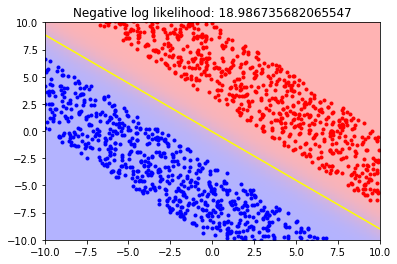

In [119]:
res_1_1 = minimize(
    negative_log_likelihood, [-1,1,2], method = 'BFGS',
    jac = gradient_negative_log_likelihood, args=(X,y,numpy.array([10,0]),))
plot_data(X,y,res_1_1.x,numpy.array([10,0]))

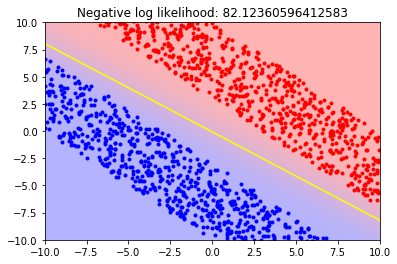

In [120]:
res_1_2 = minimize(
    negative_log_likelihood, [-1,1,2], method = 'BFGS',
    jac = gradient_negative_log_likelihood, args=(X,y,numpy.array([100,0]),))
plot_data(X,y,res_1_2.x,numpy.array([100,0]))

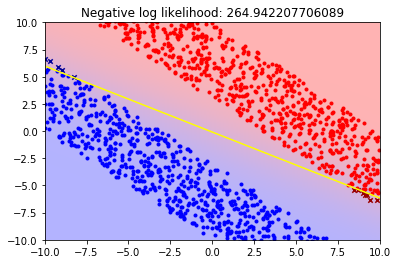

In [121]:
res_1_3 = minimize(
    negative_log_likelihood, [-1,1,2], method = 'BFGS',
    jac = gradient_negative_log_likelihood, args=(X,y,numpy.array([1e3,0]),))
plot_data(X,y,res_1_3.x,numpy.array([1e3,0]))

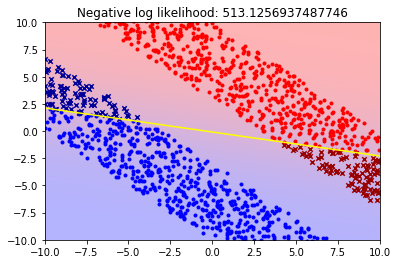

In [122]:
res_1_4 = minimize(
    negative_log_likelihood, [-1,1,2], method = 'BFGS',
    jac = gradient_negative_log_likelihood, args=(X,y,numpy.array([1e4,0]),))
plot_data(X,y,res_1_4.x,numpy.array([1e4,0]))

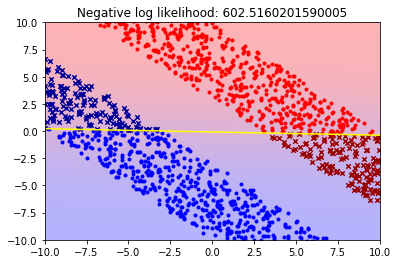

In [123]:
res_1_5 = minimize(
    negative_log_likelihood, [-1,1,2], method = 'BFGS',
    jac = gradient_negative_log_likelihood, args=(X,y,numpy.array([1e5,0]),))
plot_data(X,y,res_1_5.x,numpy.array([1e5,0]))

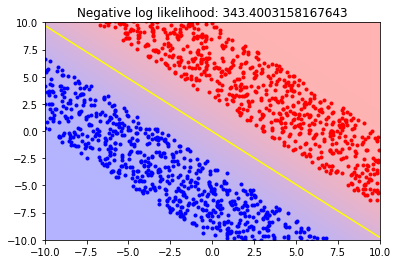

In [124]:
res_2_3 = minimize(
    negative_log_likelihood, [-1,1,2], method = 'BFGS',
    jac = gradient_negative_log_likelihood, args=(X,y,numpy.array([0,1e3]),))
plot_data(X,y,res_2_3.x,numpy.array([0,1e3]))

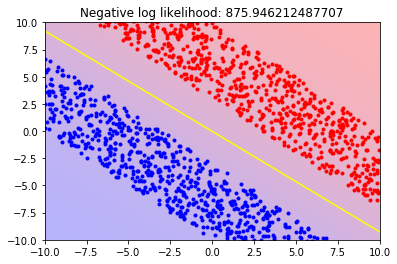

In [125]:
res_2_4 = minimize(
    negative_log_likelihood, [-1,1,2], method = 'BFGS',
    jac = gradient_negative_log_likelihood, args=(X,y,numpy.array([0,1e4]),))
plot_data(X,y,res_2_4.x,numpy.array([0,1e4]))

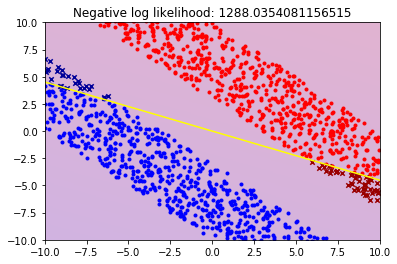

In [126]:
res_2_5 = minimize(
    negative_log_likelihood, [-1,1,2], method = 'BFGS',
    jac = gradient_negative_log_likelihood, args=(X,y,numpy.array([0,1e5]),))
plot_data(X,y,res_2_5.x,numpy.array([0,1e5]))

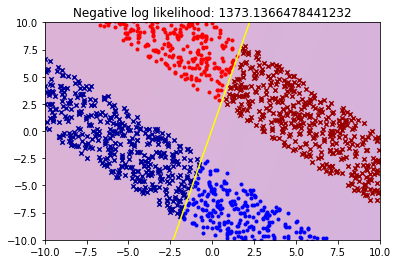

In [128]:
res_2_6 = minimize(
    negative_log_likelihood, [-1,1,2], method = 'BFGS',
    jac = gradient_negative_log_likelihood, args=(X,y,numpy.array([0,1e6]),))
plot_data(X,y,res_2_6.x,numpy.array([0,1e6]))

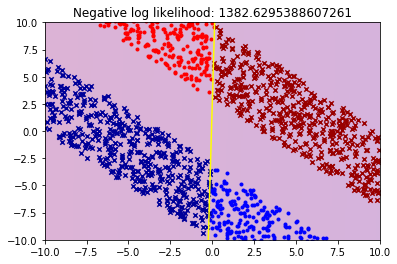

In [129]:
res_2_7 = minimize(
    negative_log_likelihood, [-1,1,2], method = 'BFGS',
    jac = gradient_negative_log_likelihood, args=(X,y,numpy.array([0,1e7]),))
plot_data(X,y,res_2_7.x,numpy.array([0,1e7]))

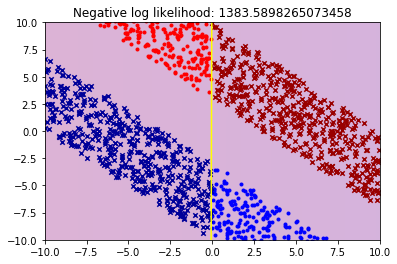

In [130]:
res_2_8 = minimize(
    negative_log_likelihood, [-1,1,2], method = 'BFGS',
    jac = gradient_negative_log_likelihood, args=(X,y,numpy.array([0,1e8]),))
plot_data(X,y,res_2_8.x,numpy.array([0,1e8]))